In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [67]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [68]:
df = pd.read_csv('heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [69]:
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

In [70]:
df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,slope_1,slope_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,1,0,0,1,0,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,0,1,0,1,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,1,0,0,0,0,0,1,0,1,0
3,56,1,120,236,0,178,0,0.8,0,1,1,0,0,1,0,0,1,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,0,0,0,0,0,1,0,1,0,0,0,1
299,45,1,110,264,0,132,0,1.2,0,0,0,0,1,1,0,1,0,0,0,1
300,68,1,144,193,1,141,0,3.4,2,0,0,0,0,1,0,1,0,0,0,1
301,57,1,130,131,0,115,1,1.2,1,0,0,0,0,1,0,1,0,0,0,1


In [71]:
X = df.drop(['target'], axis=1).values
y = df['target'].values

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [73]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
X_test_scaled = std.transform(X_test)

In [74]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return len(self.X)

In [75]:
train_data = Data(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train)
)

test_data = Data(
    torch.FloatTensor(X_test_scaled),
    torch.FloatTensor(y_test)
)

In [76]:
X_train.shape

(227, 19)

In [77]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(19, 16)
        self.act1 = nn.Tanh()
        self.linear2 = nn.Linear(16, 8)
        self.act2 = nn.Tanh()
        self.linear3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, X):
        out = self.act1(self.linear1(X))
        out = self.act2(self.linear2(out))
        out = self.sigmoid(self.linear3(out))
        return out

In [78]:
model = Net()

In [103]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, device):
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        for examples, labels in train_loader:
            examples = examples.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(examples)
            loss = loss_fn(outputs.reshape(1, -1)[0], labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        for name, loader, accuracy in [
            ('train', train_loader, train_accuracy),
            ('test', test_loader, test_accuracy)
        ]:
            correct = 0
            total = 0
            with torch.no_grad():
                for examples, labels in loader:
                    examples = examples.to(device=device)
                    labels = labels.to(device=device)
                    
                    outputs = model(examples)
                    predicted = (outputs.reshape(1, -1)[0] > 0.5).type(torch.uint8)
                    total += labels.shape[0]
                    correct += int((predicted == labels).sum())
            accuracy[epoch] = correct / total
        
    plt.figure(dpi=150)
    plt.xlabel('Number of epochs')
    plt.ylabel("Accuracy")
    plt.plot(range(1, n_epochs + 1), train_accuracy)
    plt.plot(range(1, n_epochs + 1), test_accuracy)
    plt.legend(['Train Accuracy', 'Test Accuracy'])
    plt.grid()
    plt.show()
        

In [104]:
device = torch.device('cpu')
train_loader = DataLoader(
    train_data, batch_size=32, shuffle= True
)
test_loader = DataLoader(
    test_data, batch_size=32, shuffle=True
)

In [108]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.BCELoss()

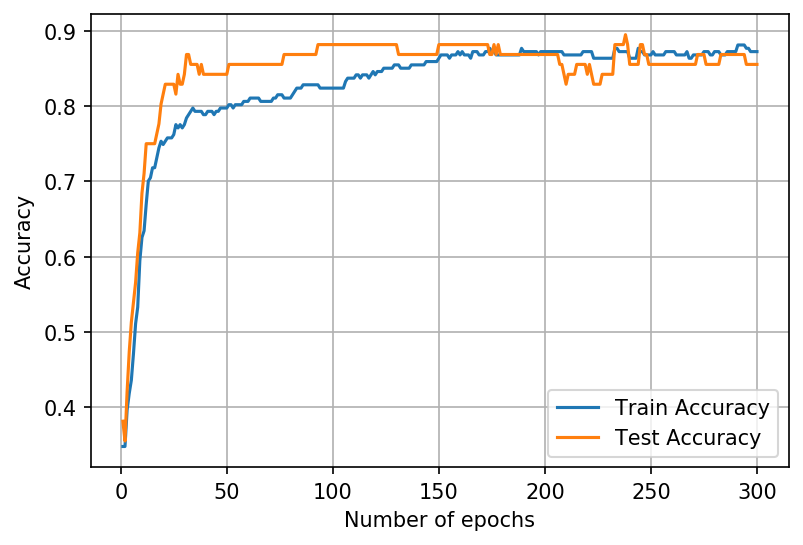

In [109]:
train(n_epochs=300, optimizer=optimizer, model=model, loss_fn=loss_fn,
      train_loader=train_loader, test_loader=test_loader, device=device)